# Experiment Tracking

The machine learning life cycle involves training multiple algorithms using different hyperparameters and libraries, all with different performance results and trained models.  This lesson explores tracking those experiments to organize the machine learning life cycle.

### Tracking Experiments with MLflow

Over the course of the machine learning life cycle, data scientists test many different models from various libraries with different hyperparameters.  Tracking these various results poses an organizational challenge.  In brief, storing experiments, results, models, supplementary artifacts, and code creates significant challenges.

MLflow Tracking is one of the three main components of MLflow.  It is a logging API specific for machine learning and agnostic to libraries and environments that do the training.  It is organized around the concept of **runs**, which are executions of data science code.  Runs are aggregated into **experiments** where many runs can be a part of a given experiment and an MLflow server can host many experiments.

Each run can record the following information:<br><br>

- **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
- **Source:** The code that originally ran the experiment

MLflow tracking also serves as a **model registry** so tracked models can easily be stored and, as necessary, deployed into production.

Experiments can be tracked using libraries in Python, R, and Java as well as by using the CLI and REST calls.  This course will use Python, though the majority of MLflow functionality is also exposed in these other APIs.

<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>

### Experiment Logging and UI

MLflow is an open source software project developed by Databricks available to developers regardless of which platform they are using.

Import a dataset of Airbnb listings and featurize the data.  We'll use this to train a model.

In [1]:
!python --version

Python 3.8.5


In [4]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

#Azure
import azureml.core
import azureml.dataprep
from azureml.core import Workspace, Dataset
from azure.storage.blob import BlobServiceClient
from azureml.core.authentication import ServicePrincipalAuthentication

#MLFlow
import mlflow
import mlflow.sklearn
from mlflow.entities import ViewType

#Temporarily filter all warning for demo
warnings.filterwarnings("ignore")

In [5]:
# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.13.0


In [9]:
data_path = "/Users/antfra/Desktop/MLFlow In Azure/data/airbnb_sample.csv" #put your path here
df = pd.read_csv(data_path)

df.sample(10)

,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
2090,2.0,31,25,37.713248,-122.469861,1,0,5.0,1.0,2.0,...,1.0,3.0,93.0,10.0,10.0,9.0,10.0,10.0,9.0,150.0
3128,4.0,4,1,37.756527,-122.409218,0,1,1.0,2.0,3.0,...,1.0,24.0,96.0,10.0,10.0,9.0,10.0,9.0,9.0,69.0
3226,23.0,6,5,37.787223,-122.408172,0,1,2.0,1.0,1.0,...,1.0,99.0,88.0,9.0,9.0,9.0,9.0,9.0,9.0,89.0
3506,1.0,25,17,37.764631,-122.474559,1,0,7.0,2.0,3.0,...,6.0,8.0,95.0,9.0,9.0,9.0,10.0,10.0,10.0,215.0
4124,4.0,2,0,37.769154,-122.448681,0,1,2.0,1.0,1.0,...,2.0,4.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,150.0
2385,1.0,1,1,37.740255,-122.412591,0,0,2.0,1.0,1.0,...,30.0,92.0,96.0,10.0,10.0,10.0,10.0,9.0,9.0,150.0
3105,15.0,26,18,37.797858,-122.425715,4,0,2.0,1.0,1.0,...,1.0,117.0,88.0,9.0,9.0,10.0,10.0,10.0,9.0,99.0
4423,2.0,15,4,37.778249,-122.401181,12,0,2.0,2.0,1.0,...,2.0,4.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,279.0
2589,1.0,2,0,37.771331,-122.447103,0,0,2.0,1.0,1.0,...,2.0,76.0,95.0,10.0,10.0,10.0,10.0,9.0,9.0,169.0
2560,4.0,2,0,37.768923,-122.446147,0,0,6.0,1.0,3.0,...,30.0,110.0,95.0,10.0,9.0,10.0,10.0,10.0,9.0,189.0


Perform a train/test split.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(["price"], axis=1), df[["price"]].values.ravel(), random_state=42)

Log a basic experiment by doing the following:<br><br>

1. Start an experiment using `mlflow.start_run()` and passing it a name for the run
2. Train your model
3. Log the model using `mlflow.sklearn.log_model()`
4. Log the model error using `mlflow.log_metric()`
5. Print out the run id using `run.info.run_uuid`

In [11]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### To create an experiment in MLFlow

#### List Experiments

In [14]:
mlflow.tracking.MlflowClient().list_experiments()

[<Experiment: artifact_location='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Simple Experiment', tags={}>]

In [13]:
mlflow.create_experiment("Simple Experiment")
#output is the experiment_id

'1'

### Execute A Run

In [15]:
with mlflow.start_run(run_name="RF Experiment 1",experiment_id=mlflow.tracking.MlflowClient().list_experiments()[1].experiment_id) as run:
  # Create model, train it, and create predictions
  rf=RandomForestRegressor()
  rf.fit(X_train,y_train)
  predictions=rf.predict(X_test)
  
  #log model
  mlflow.sklearn.log_model(rf,"random-forest-model")
  
  # Create & log metrics
  mse=mean_squared_error(y_test,predictions)
  mlflow.log_metric("mse",mse)
  print(f"MSE: {mse}")
  
  # Metadata
  runID=run.info.run_uuid
  experimentID = run.info.experiment_id
  
  print(f"The runID ={runID} and the experimentID={experimentID}")
  

MSE: 7986.518118521665
The runID =9545cfdfaca64100921dcad85f74f1d1 and the experimentID=1


### Start A New Run

In [16]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

with mlflow.start_run(run_name="Basic RF Experiment") as run:
  # Create model, train it, and create predictions
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train)
  predictions = rf.predict(X_test)
  
  # Log model
  mlflow.sklearn.log_model(rf, "random-forest-model")
  
  # Create metrics
  mse = mean_squared_error(y_test, predictions)
  print("  mse: {}".format(mse))
  
  # Log metrics
  mlflow.log_metric("mse", mse)
  
  runID = run.info.run_uuid
  experimentID = run.info.experiment_id
  
  print("Inside MLflow Run with run_id {} and experiment_id {}".format(runID, experimentID))

  mse: 7928.654443245539
Inside MLflow Run with run_id 301e5810b6454610a362bd8e7f8cc038 and experiment_id 0


Now take a look at the directory structure backing this experiment.  This allows you to retrieve artifacts.

In [17]:
from mlflow.tracking import MlflowClient

artifactURL = MlflowClient().get_experiment(experimentID).artifact_location
print(artifactURL)
print(MlflowClient().list_experiments())

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0
[<Experiment: artifact_location='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>, <Experiment: artifact_location='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Simple Experiment', tags={}>]


In [18]:
print(artifactURL,'\n',runID)

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0 
 301e5810b6454610a362bd8e7f8cc038


Take a look at the contents of `random-forest-model`, which match what we see in the UI.

In [19]:
artifacts_folderURL=artifactURL + "/" +runID+"/artifacts/"
print(artifacts_folderURL)

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/301e5810b6454610a362bd8e7f8cc038/artifacts/


In [20]:
modelURL = artifactURL + "/" + runID + "/artifacts/random-forest-model"
print(modelURL)

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/301e5810b6454610a362bd8e7f8cc038/artifacts/random-forest-model


### Parameters, Metrics, and Artifacts

But wait, there's more!  In the last example, you logged the run name, an evaluation metric, and your model itself as an artifact.  Now let's log parameters, multiple metrics, and other artifacts including the feature importances.

First, create a function to perform this.

In [21]:
def log_rf(experimentID, run_name, params, X_train, X_test, y_train, y_test):
  import os
  import matplotlib.pyplot as plt
  import mlflow.sklearn
  import seaborn as sns
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
  import tempfile

  with mlflow.start_run(experiment_id=experimentID, run_name=run_name) as run:
    # Create model, train it, and create predictions
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)

    # Log model
    mlflow.sklearn.log_model(rf, "random-forest-model")

    # Log params
    [mlflow.log_param(param, value) for param, value in params.items()]

    # Create metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print("  mse: {}".format(mse))
    print("  mae: {}".format(mae))
    print("  R2: {}".format(r2))

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)  
    mlflow.log_metric("r2", r2)  
    
    # Create feature importance
    importance = pd.DataFrame(list(zip(df.columns, rf.feature_importances_)), 
                                columns=["Feature", "Importance"]
                              ).sort_values("Importance", ascending=False)
    
    # Log importances using a temporary file
    temp = tempfile.NamedTemporaryFile(prefix="feature-importance-", suffix=".csv")
    temp_name = temp.name
    print(temp_name)
    try:
      importance.to_csv(temp_name, index=False)
      mlflow.log_artifact(temp_name, "feature-importance.csv")
    finally:
      temp.close() # Delete the temp file
    
    # Create plot
    fig, ax = plt.subplots()

    sns.residplot(predictions, y_test, lowess=True)
    plt.xlabel("Predicted values for Price ($)")
    plt.ylabel("Residual")
    plt.title("Residual Plot")

    # Log residuals using a temporary file
    temp = tempfile.NamedTemporaryFile(prefix="residuals-", suffix=".png")
    temp_name = temp.name
    print(temp_name)
    try:
      fig.savefig(temp_name)
      mlflow.log_artifact(temp_name, "residuals.png")
    finally:
      temp.close() # Delete the temp file
    
    print(run.info.run_uuid)
    display(fig)
    
    return run.info.run_uuid

Run with new parameters.

  mse: 8652.849726178441
  mae: 56.02275226231014
  R2: 0.6272202130602629
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/feature-importance-_4xaku65.csv
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/residuals-k2i36e0d.png
58830ca8e4ea413387bf82e573ef3ca1


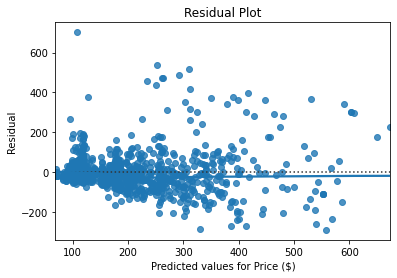

'58830ca8e4ea413387bf82e573ef3ca1'

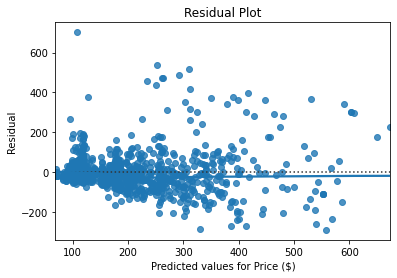

In [24]:
params = {
  "n_estimators": 100,
  "max_depth": 5,
  "random_state": 42
}

log_rf(experimentID, "Second Run", params, X_train, X_test, y_train, y_test)

Check the UI to see how this appears.  Take a look at the artifact to see where the plot was saved.

Now, run a third run.

  mse: 7868.665325354859
  mae: 51.213729259361386
  R2: 0.6610042383364754
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/feature-importance-q6_km1rx.csv
/var/folders/n6/qmpybzn97zb7xrz6gb04rfy00000gn/T/residuals-rbjtget1.png
77c453fd42284825b1e8058f7dbef648


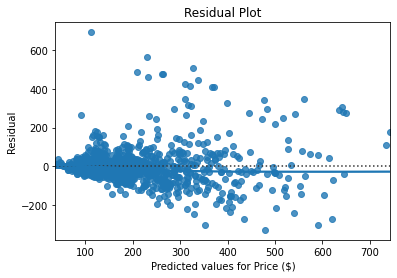

'77c453fd42284825b1e8058f7dbef648'

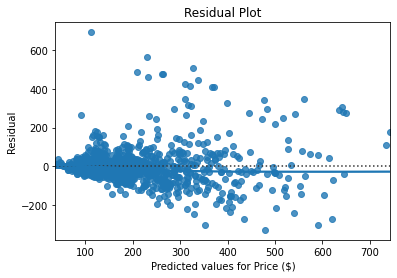

In [25]:
params_1000_trees = {
  "n_estimators": 1000,
  "max_depth": 10,
  "random_state": 42
}

log_rf(experimentID, "Third Run", params_1000_trees, X_train, X_test, y_train, y_test)

### Querying Past Runs

You can query past runs programatically in order to use this data back in Python.  The pathway to doing this is an `MlflowClient` object. 

In [26]:
from  mlflow.tracking import MlflowClient

client = MlflowClient()

Now list all the runs for your experiment using `.list_run_infos()`, which takes your `experiment_id` as a parameter.

In [27]:
client.list_run_infos(experimentID)

[<RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/77c453fd42284825b1e8058f7dbef648/artifacts', end_time=1600416414685, experiment_id='0', lifecycle_stage='active', run_id='77c453fd42284825b1e8058f7dbef648', run_uuid='77c453fd42284825b1e8058f7dbef648', start_time=1600416405221, status='FINISHED', user_id='antfra'>,
 <RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/58830ca8e4ea413387bf82e573ef3ca1/artifacts', end_time=1600416398779, experiment_id='0', lifecycle_stage='active', run_id='58830ca8e4ea413387bf82e573ef3ca1', run_uuid='58830ca8e4ea413387bf82e573ef3ca1', start_time=1600416397806, status='FINISHED', user_id='antfra'>,
 <RunInfo: artifact_uri='file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/bd6ab775c3c54e44b4e6ca069f63c0c9/artifacts', end_time=1600416354835, experiment_id='0', lifecycle_stage='active', run_id='bd6ab775c3c54e44b4e6ca069f63c0c9', run_uuid='bd6ab775c3c54e44b4e6ca

Pull out a few fields and create a pandas DataFrame with it.

In [32]:
runs = pd.DataFrame([(run.run_uuid, run.start_time, run.artifact_uri) for run in client.list_run_infos(experimentID)])
runs.columns = ["run_uuid", "start_time", "artifact_uri"]

display(runs)

,run_uuid,start_time,artifact_uri
0,77c453fd42284825b1e8058f7dbef648,1600416405221,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
1,58830ca8e4ea413387bf82e573ef3ca1,1600416397806,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
2,bd6ab775c3c54e44b4e6ca069f63c0c9,1600416354245,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...
3,301e5810b6454610a362bd8e7f8cc038,1600416172582,file:///Users/antfra/Desktop/MLFlow%20In%20Azu...


Pull the last run and take a look at the associated artifacts.

In [61]:
last_run = runs.sort_values("start_time", ascending=False).iloc[0]

print(last_run.artifact_uri+ "/random-forest-model/")

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/77c453fd42284825b1e8058f7dbef648/artifacts/random-forest-model/


In [80]:
from pathlib import Path

filename=Path(last_run.artifact_uri+ "/random-forest-model/")
print(filename)
for x in filename.rglob('**/*'):
    print(x)

file:/Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/77c453fd42284825b1e8058f7dbef648/artifacts/random-forest-model


Return the evaluation metrics for the last run.

In [43]:
client.get_run(last_run.run_uuid).data.metrics

{'mae': 51.213729259361386, 'mse': 7868.665325354859, 'r2': 0.6610042383364754}

In [51]:
client.get_run(last_run.run_uuid)

<Run: data=<RunData: metrics={'mae': 51.213729259361386, 'mse': 7868.665325354859, 'r2': 0.6610042383364754}, params={'max_depth': '10', 'n_estimators': '1000', 'random_state': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "77c453fd42284825b1e8058f7dbef648", '
                             '"artifact_path": "random-forest-model", '
                             '"utc_time_created": "2020-09-18 '
                             '08:06:54.083834", "flavors": {"python_function": '
                             '{"model_path": "model.pkl", "loader_module": '
                             '"mlflow.sklearn", "python_version": "3.8.5", '
                             '"env": "conda.yaml"}, "sklearn": '
                             '{"pickled_model": "model.pkl", '
                             '"sklearn_version": "0.23.2", '
                             '"serialization_format": "cloudpickle"}}}]',
 'mlflow.runName': 'Third Run',
 'mlflow.source.git.commit': '70635dade88cc31365a8a0b2275b639981c

Reload the model and take a look at the feature importance.

In [57]:
print(last_run.artifact_uri)

file:///Users/antfra/Desktop/MLFlow%20In%20Azure/notebooks/mlruns/0/77c453fd42284825b1e8058f7dbef648/artifacts


In [58]:
import mlflow.sklearn

model = mlflow.sklearn.load_model(last_run.artifact_uri + "/random-forest-model/")
model.feature_importances_

array([0.02322258, 0.02051433, 0.01753094, 0.10215433, 0.04884614,
       0.01454922, 0.05496871, 0.06026611, 0.11730059, 0.43356225,
       0.00912555, 0.00439141, 0.0202865 , 0.03151115, 0.02182316,
       0.00238272, 0.00531728, 0.00142615, 0.00091983, 0.00564621,
       0.00425484])